In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.style.use("fivethirtyeight")
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, accuracy_score,confusion_matrix, roc_curve, auc,classification_report, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/install_package/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 12.1场景介绍

# 12.2数据准备

一、读取数据




sampleEntry.csv

该数据集已经划分好了训练集（cs-training.csv）和测试集（cs-test.csv）。读取时对于一些无效的索引列，可以使用dataframe的drop函数去除。


In [2]:
# 加载数据集
data = pd.read_csv("./dataset/GiveMeSomeCredit/cs-training.csv")
data.drop("Unnamed: 0", axis=1, inplace=True)
y_col='SeriousDlqin2yrs'
data.shape

(150000, 11)

二、分析因变量

SeriousDlqin2yrs为被解释变量，代表客户是否发生90天及以上的逾期行为，发生则为1，未发生则为0。通过datframe的value_counts函数可以统计出，正样本139974条，负样本10026条,负样本占比约为6.58%，属于有偏数据。

In [3]:
y_col='SeriousDlqin2yrs'
print(data[y_col].value_counts())

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64


三、分析自变量

In [4]:
# 统计缺失值  
data.isnull().sum(axis=0)  

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

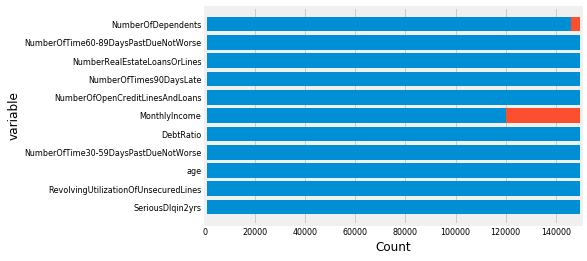

In [5]:
# 可视化缺失值
cols = data.columns
nullcounts = []
value_counts = []
for col in cols:
    nullcounts.append(data[col].isnull().sum())
    value_counts.append(data[col].shape[0] - data[col].isnull().sum())

fig, ax = plt.subplots()
ax.barh(cols, value_counts, label='not missing')
ax.barh(cols, nullcounts, label='missing', left=value_counts)
ax.set_xlabel('Count')
ax.set_ylabel('variable')
plt.show()

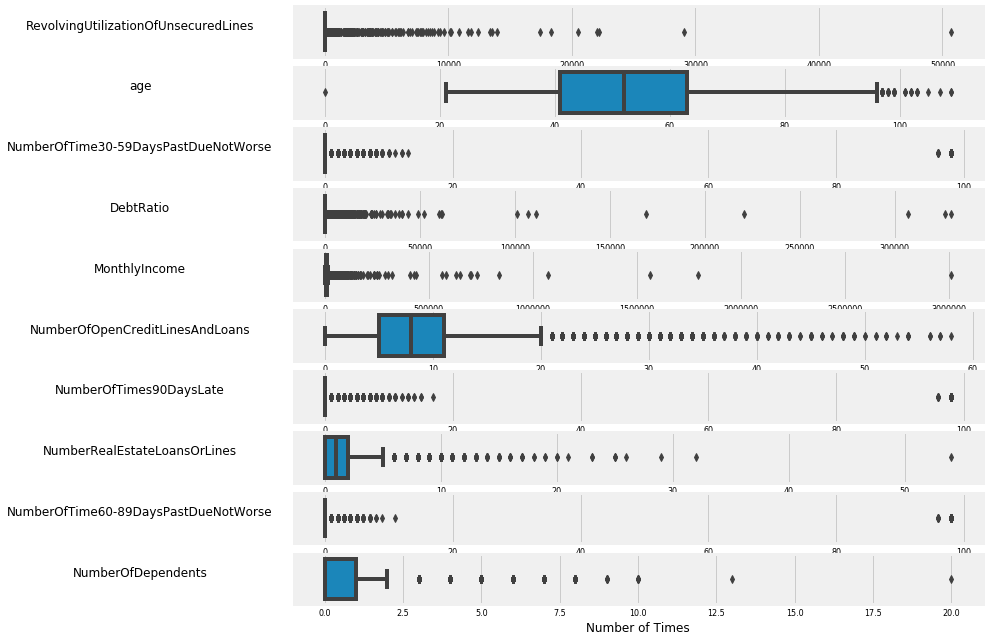

In [6]:
# 批量画箱线图（此图要改）
x_cols =data.columns.tolist().copy()
x_cols.remove('SeriousDlqin2yrs')
fig, axes = plt.subplots(len(x_cols),1, figsize=(11,11))
i = 0
for c in x_cols:
    #ax=plt.boxplot(train_data[c], vert=False,ax = axes[i])
   
    ax = sns.boxplot(data[c], ax = axes[i])
    ax.set_ylabel(c, rotation=0,labelpad=150)
    ax.set_xlabel("Number of Times")
    i +=1
plt.show()

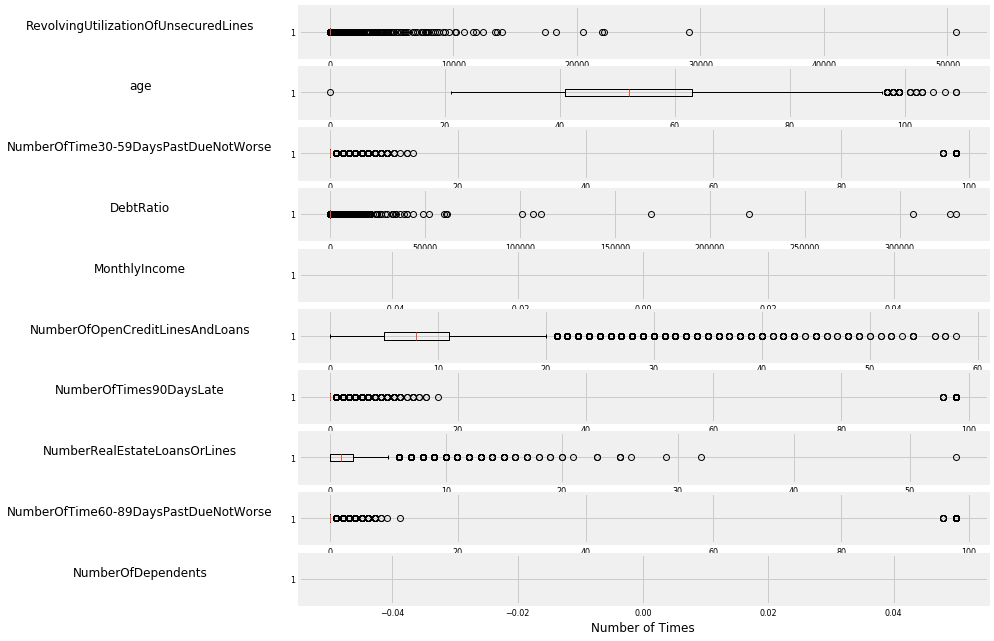

In [7]:
# 批量画箱线图（此图要改）
x_cols =data.columns.tolist().copy()
x_cols.remove('SeriousDlqin2yrs')
fig, axes = plt.subplots(len(x_cols),1, figsize=(11,11))
i = 0
for c in x_cols:
    #ax=plt.boxplot(train_data[c], vert=False,ax = axes[i])
    
    ax = axes[i]
    ax.boxplot(data[c],vert=False)
    ax.set_ylabel(c, rotation=0,labelpad=150)
    ax.set_xlabel("Number of Times")
    i +=1
plt.show()

三、数据预处理

In [8]:
for col in ['NumberOfDependents','NumberOfTime30-59DaysPastDueNotWorse',
            'NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse',
            'NumberRealEstateLoansOrLines']:
    print(col,np.sort(data[col].unique(), axis=-1)[-5:])

NumberOfDependents [ 9. 10. 13. 20. nan]
NumberOfTime30-59DaysPastDueNotWorse [11 12 13 96 98]
NumberOfTimes90DaysLate [14 15 17 96 98]
NumberOfTime60-89DaysPastDueNotWorse [ 8  9 11 96 98]
NumberRealEstateLoansOrLines [25 26 29 32 54]


In [9]:
# 数据预处理
import math
# 处理NumberOfDependents
data.dropna(subset=['NumberOfDependents'],inplace=True)
data['NumberOfDependents']=data['NumberOfDependents'].apply(
    lambda x:10 if x>10 else x)
# 处理age
data['age']=data.apply(lambda x: data[data[y_col]==1]['age'].mean() 
                   if x['age']!=x['age'] and x[y_col]==1 else x['age'],axis=1)
data['age']=data.apply(lambda x: data[data[y_col]==0]['age'].mean() 
                   if x['age']!=x['age'] and x[y_col]==1 else x['age'],axis=1)
# 处理NumberOfTime30-59DaysPastDueNotWorse等
data.drop(data[(data['NumberOfTime30-59DaysPastDueNotWorse']>90)
        |(data['NumberOfTimes90DaysLate']>90)
        |(data['NumberOfTime60-89DaysPastDueNotWorse']>90)].index,inplace=True)
data['defaut times']=data['NumberOfTime30-59DaysPastDueNotWorse']
+data['NumberOfTimes90DaysLate']+data['NumberOfTime60-89DaysPastDueNotWorse']
del data['NumberOfTime30-59DaysPastDueNotWorse']
del data['NumberOfTimes90DaysLate']
del data['NumberOfTime60-89DaysPastDueNotWorse']
# 处理MonthlyIncome
data['MonthlyIncome'].fillna(data['MonthlyIncome'].mean(), inplace=True)
data['MonthlyIncome']= data['MonthlyIncome'].map(lambda x: math.log(x+1))
# 处理NumberRealEstateLoansOrLines，与NumberOfOpenCreditLinesAndLoans
data.drop(data[data['NumberRealEstateLoansOrLines']>50].index,inplace=True)
data['loan times']=data['NumberRealEstateLoansOrLines']
+data['NumberOfOpenCreditLinesAndLoans']
del data['NumberRealEstateLoansOrLines'],data['NumberOfOpenCreditLinesAndLoans']    

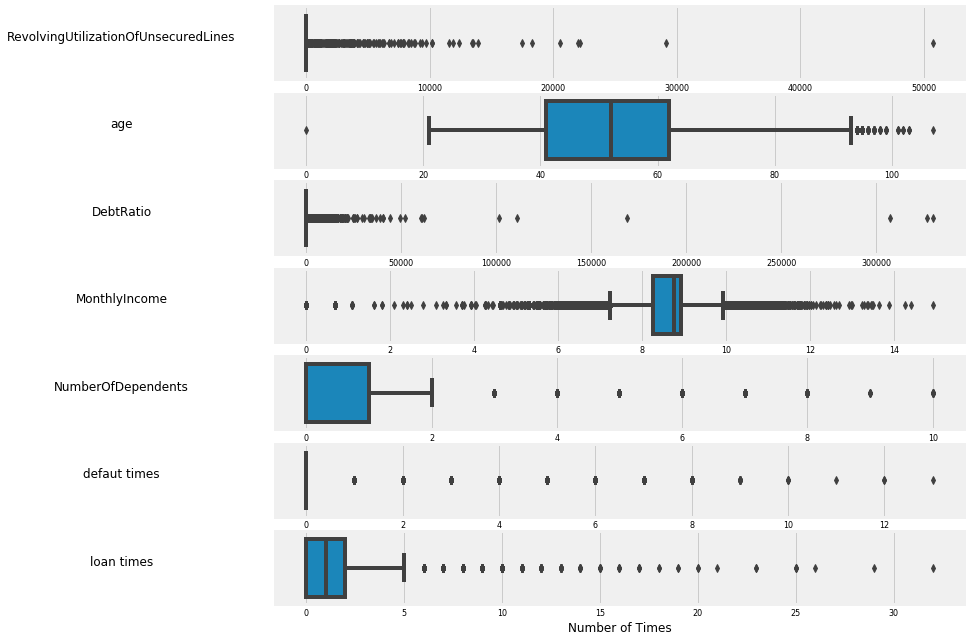

In [10]:
# 批量画箱线图（此图要改）
x_cols =data.columns.tolist().copy()
x_cols.remove('SeriousDlqin2yrs')
fig, axes = plt.subplots(len(x_cols),1, figsize=(11,11))
i = 0
for c in x_cols:
    #ax=plt.boxplot(train_data[c], vert=False,ax = axes[i])
   
    ax = sns.boxplot(data[c], ax = axes[i])
    ax.set_ylabel(c, rotation=0,labelpad=150)
    ax.set_xlabel("Number of Times")
    i +=1
plt.show()

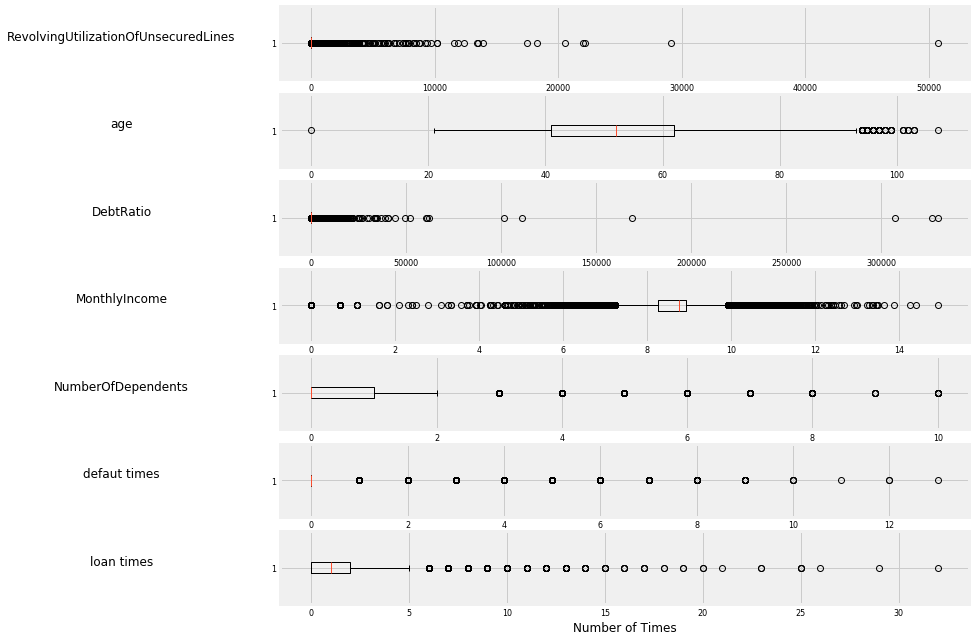

In [11]:
# 批量画箱线图（此图要改）
x_cols =data.columns.tolist().copy()
x_cols.remove('SeriousDlqin2yrs')
fig, axes = plt.subplots(len(x_cols),1, figsize=(11,11))
i = 0
for c in x_cols:
    #ax=plt.boxplot(train_data[c], vert=False,ax = axes[i])
    
    ax = axes[i]
    ax.boxplot(data[c], vert=False)
    ax.set_ylabel(c, rotation=0,labelpad=150)
    ax.set_xlabel("Number of Times")
    i +=1
plt.show()

In [12]:
# 统计缺失值
data.isnull().sum(axis=0)

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
DebtRatio                               0
MonthlyIncome                           0
NumberOfDependents                      0
defaut times                            0
loan times                              0
dtype: int64

In [13]:
from sklearn.tree import DecisionTreeClassifier
def optimal_binning_boundary(x: pd.Series, y: pd.Series, nan: float = -999.):
   # 利用决策树获得最优分箱的边界值列表
    boundary = []  # 待return的分箱边界值列表
    
    x = x.replace('-',np.nan)
    x = x.replace('—',np.nan)
    x = x.replace('未公开',np.nan)
    x = x.replace('未知',np.nan)
    x = x.values
    y = y.values
    
    clf = DecisionTreeClassifier(criterion='entropy',    #“信息熵”最小化准则划分
                                 max_leaf_nodes=6,       # 最大叶子节点数
                                 min_samples_leaf=0.05)  # 叶子节点样本数量最小占比

    clf.fit(x.reshape(-1, 1), y)  # 训练决策树
    
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    threshold = clf.tree_.threshold
    
    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  # 获得决策树节点上的划分边界值
            boundary.append(threshold[i])

    boundary.sort()

    min_x = x.min()
    max_x = x.max() + 1e-7  # 保证后续groupby操作时，能包含特征最大值的样本
    boundary = [min_x] + boundary + [max_x]

    return boundary

In [14]:
def feature_continuous_woe_iv(df,column,label, nan: float = -999.):
    # 计算变量各个分箱的WOE、IV值，返回一个DataFrame
    x=df[column]
    y=df[label]
    boundary = optimal_binning_boundary(x, y, nan)
    # 获得最优分箱边界值列表
    df = df[[column,label]]     
    df.columns = ['x', 'y']                               # 特征变量、目标变量字段的重命名
    df[column] = pd.cut(x=x, bins=boundary, right=False)  # 获得每个x值所在的分箱区间
    
    grouped = df.groupby(column)['y']                     # 统计各分箱区间的好、坏、总客户数量
    result_df = grouped.agg([('good',  lambda y: (y == 0).sum()), 
                             ('bad',   lambda y: (y == 1).sum()),
                             ('total', 'count')])

    result_df['good_pct'] = result_df['good'] / result_df['good'].sum()       # 好客户占比
    result_df['bad_pct'] = result_df['bad'] / result_df['bad'].sum()          # 坏客户占比
    result_df['total_pct'] = result_df['total'] / result_df['total'].sum()    # 总客户占比

    result_df['bad_rate'] = result_df['bad'] / result_df['total']             # 坏比率
    result_df['woe'] = np.log(result_df['good_pct'] /  (result_df['bad_pct']+0.0001))         # WOE   +0.001防止分母为0
    result_df['iv'] = (result_df['good_pct'] - result_df['bad_pct']) * result_df['woe']  # IV
    
    print(column+f" 信息量IV = {result_df['iv'].sum()}")
    
    return result_df

In [15]:
data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'DebtRatio', 'MonthlyIncome', 'NumberOfDependents', 'defaut times',
       'loan times'],
      dtype='object')

WOE（Weight of Evidence）称为证据权重。WOE是对原始自变量的一种编码形式。要对一个变量进行WOE编码，需要首先把这个变量进行分组处理。
计算公式为Ln（正样本占比/负样本占比）。
WOE表示的实际上是“当前分组中响应客户占所有响应客户的比例”和“当前分组中没有响应的客户占所有没有响应的客户的比例”的差异。
（信息值与预测能力解释对照）

另一个重要指标未信息值IV（Information Value）。
我们需要一些具体的量化指标来衡量每自变量的预测能力，并根据这些量化指标的大小，来确定哪些变量进入模型。
IV就是这样一种指标，他可以用来衡量自变量的预测能力。类似的指标还有信息增益、基尼系数等等。

（信息值与预测能力解释对照）
0.03 无预测能力
0.03-0.09 低
0.10-0.29 中
0.30-0.49 高
0.50 极高

In [16]:
# 计算age的WOE和IV值
feature_continuous_woe_iv(data,'RevolvingUtilizationOfUnsecuredLines',y_col)

RevolvingUtilizationOfUnsecuredLines 信息量IV = 1.0678392664502958


,good,bad,total,good_pct,bad_pct,total_pct,bad_rate,woe,iv
RevolvingUtilizationOfUnsecuredLines,,,,,,,,,
"[0.0, 0.186)",75492,1541,77033,0.554579,0.158670,0.528213,0.020004,1.250754,0.495184
"[0.186, 0.301)",12473,480,12953,0.091629,0.049423,0.088818,0.037057,0.615303,0.025969
"[0.301, 0.495)",14345,884,15229,0.105381,0.091021,0.104425,0.058047,0.145390,0.002088
"[0.495, 0.698)",10388,1094,11482,0.076312,0.112644,0.078732,0.095280,-0.390288,0.014180
"[0.698, 0.86)",6666,1081,7747,0.048970,0.111306,0.053121,0.139538,-0.821976,0.051239
"[0.86, 50708.0)",16761,4632,21393,0.123129,0.476936,0.146691,0.216519,-1.354355,0.479179


In [17]:
feature_continuous_woe_iv(data,'age',y_col)

age 信息量IV = 0.24216316542967298


,good,bad,total,good_pct,bad_pct,total_pct,bad_rate,woe,iv
age,,,,,,,,,
"[0.0, 35.5)",18518,2259,20777,0.136037,0.232599,0.142467,0.108726,-0.536820,0.051836
"[35.5, 42.5)",17789,1796,19585,0.130681,0.184926,0.134294,0.091703,-0.347734,0.018863
"[42.5, 53.5)",36054,3060,39114,0.264860,0.315074,0.268204,0.078233,-0.173926,0.008734
"[53.5, 56.5)",9660,655,10315,0.070964,0.067442,0.070730,0.063500,0.049421,0.000174
"[56.5, 63.5)",22473,1098,23571,0.165091,0.113056,0.161626,0.046583,0.377729,0.019655
"[63.5, 107.0)",31631,844,32475,0.232367,0.086903,0.222680,0.025989,0.982379,0.142901


In [18]:
feature_continuous_woe_iv(data,'DebtRatio',y_col)

DebtRatio 信息量IV = 0.08602869349315952


,good,bad,total,good_pct,bad_pct,total_pct,bad_rate,woe,iv
DebtRatio,,,,,,,,,
"[0.0, 0.0192)",11901,537,12438,0.087427,0.055292,0.085287,0.043174,0.456361,0.014665
"[0.0192, 0.137)",16285,1203,17488,0.119633,0.123867,0.119915,0.068790,-0.035592,0.000151
"[0.137, 0.423)",50470,3083,53553,0.370762,0.317442,0.367211,0.057569,0.154950,0.008262
"[0.423, 0.654)",19453,1728,21181,0.142905,0.177924,0.145237,0.081583,-0.219737,0.007695
"[0.654, 3.973)",12802,1685,14487,0.094046,0.173497,0.099337,0.116311,-0.612952,0.048699
"[3.973, 329664.0)",25214,1476,26690,0.185227,0.151977,0.183013,0.055302,0.197195,0.006557


In [19]:
feature_continuous_woe_iv(data,'MonthlyIncome',y_col)

MonthlyIncome 信息量IV = 0.07561169839919427


,good,bad,total,good_pct,bad_pct,total_pct,bad_rate,woe,iv
MonthlyIncome,,,,,,,,,
"[0.0, 7.32)",7059,535,7594,0.051857,0.055086,0.052072,0.070450,-0.062233,2.009968e-04
"[7.32, 8.112)",19121,2070,21191,0.140466,0.213138,0.145306,0.097683,-0.417442,3.033629e-02
"[8.112, 8.58)",27985,2415,30400,0.205583,0.248661,0.208452,0.079441,-0.190644,8.212631e-03
"[8.58, 8.802)",15050,1076,16126,0.110560,0.110791,0.110576,0.066725,-0.002986,6.886563e-07
"[8.802, 8.943)",33629,1987,35616,0.247045,0.204592,0.244218,0.055790,0.188063,7.983782e-03
"[8.943, 14.917)",33281,1629,34910,0.244489,0.167731,0.239377,0.046663,0.376213,2.887731e-02


In [20]:
feature_continuous_woe_iv(data,'NumberOfDependents',y_col)

NumberOfDependents 信息量IV = 0.034710313043996


,good,bad,total,good_pct,bad_pct,total_pct,bad_rate,woe,iv
NumberOfDependents,,,,,,,,,
"[0.0, 0.5)",81721,4992,86713,0.600338,0.514003,0.594588,0.057569,0.155068,0.013388
"[0.5, 1.5)",24372,1921,26293,0.179041,0.197797,0.180290,0.073061,-0.100128,0.001878
"[1.5, 2.5)",17931,1571,19502,0.131725,0.161759,0.133725,0.080556,-0.206011,0.006187
"[2.5, 10.0)",12101,1228,13329,0.088896,0.126442,0.091397,0.092130,-0.353101,0.013257


In [21]:
feature_continuous_woe_iv(data,'defaut times',y_col)

defaut times 信息量IV = 0.7087979546804426


,good,bad,total,good_pct,bad_pct,total_pct,bad_rate,woe,iv
defaut times,,,,,,,,,
"[0.0, 0.5)",117553,4949,122502,0.863567,0.509576,0.839993,0.040399,0.527296,0.186658
"[0.5, 1.5)",13382,2363,15745,0.098307,0.243307,0.107963,0.150079,-0.906644,0.131464
"[1.5, 13.0)",5190,2400,7590,0.038127,0.247117,0.052044,0.316206,-1.869351,0.390676


In [22]:
feature_continuous_woe_iv(data,'loan times',y_col)

loan times 信息量IV = 0.05185832324751488


,good,bad,total,good_pct,bad_pct,total_pct,bad_rate,woe,iv
loan times,,,,,,,,,
"[0.0, 0.5)",49234,4421,53655,0.361682,0.455210,0.367911,0.082397,-0.230212,0.021531
"[0.5, 1.5)",48477,2714,51191,0.356121,0.279448,0.351015,0.053017,0.242097,0.018562
"[1.5, 2.5)",29411,1745,31156,0.216059,0.179675,0.213636,0.056008,0.183846,0.006689
"[2.5, 32.0)",9003,832,9835,0.066138,0.085667,0.067438,0.084596,-0.259897,0.005076


In [23]:
feature_continuous_woe_iv(data,'NumberOfDependents',y_col)

NumberOfDependents 信息量IV = 0.034710313043996


,good,bad,total,good_pct,bad_pct,total_pct,bad_rate,woe,iv
NumberOfDependents,,,,,,,,,
"[0.0, 0.5)",81721,4992,86713,0.600338,0.514003,0.594588,0.057569,0.155068,0.013388
"[0.5, 1.5)",24372,1921,26293,0.179041,0.197797,0.180290,0.073061,-0.100128,0.001878
"[1.5, 2.5)",17931,1571,19502,0.131725,0.161759,0.133725,0.080556,-0.206011,0.006187
"[2.5, 10.0)",12101,1228,13329,0.088896,0.126442,0.091397,0.092130,-0.353101,0.013257


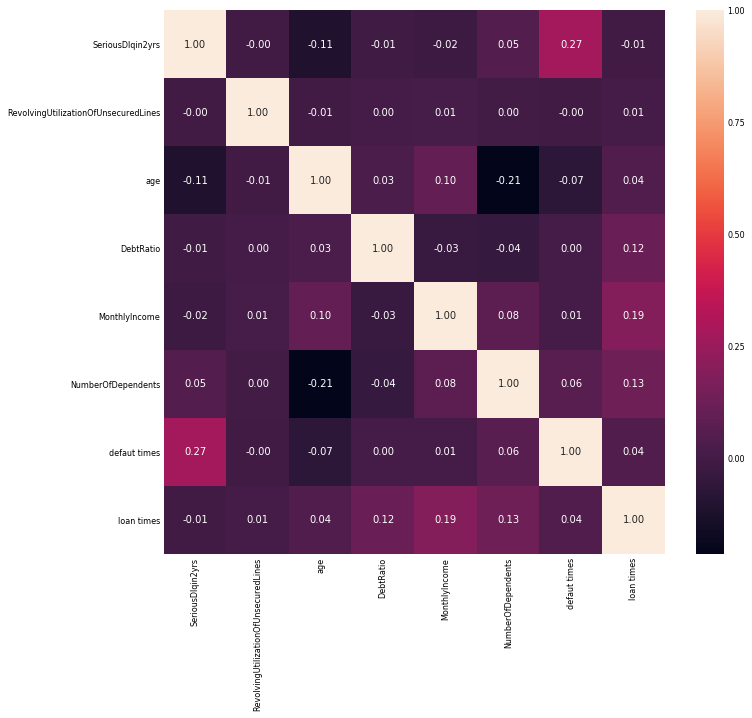

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, fmt=".2f")

In [25]:
data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'DebtRatio', 'MonthlyIncome', 'NumberOfDependents', 'defaut times',
       'loan times'],
      dtype='object')

In [26]:
x_col=['RevolvingUtilizationOfUnsecuredLines', 'age',
       'DebtRatio', 'MonthlyIncome', 'NumberOfDependents',
       'defaut times','loan times']

In [27]:
print(data[y_col].value_counts()) 

0    136125
1      9712
Name: SeriousDlqin2yrs, dtype: int64


In [28]:
9712/(136125+9712)

0.06659489704258864

In [29]:
from sklearn.model_selection import train_test_split

# 切分数据
data=data[x_col+[y_col]]
X_train, X_test, y_train, y_test  = train_test_split(data[x_col], data[y_col], 
                                                     test_size=0.3,random_state=2020)

train_data = pd.concat([X_train, y_train], axis=1)     # 合并x、y为一个DataFrame，方便后续计算
# bdf.columns = ['x', 'y'] 

# 采样规模，只补一半
sample_scale=int(0.5*(train_data.iloc[:,-1].value_counts().max()-train_data.iloc[:,-1].value_counts().min()))
# 采样
upsampling=train_data[train_data.iloc[:,-1]==1].sample(n=sample_scale,replace=True,axis=0,random_state=2020)

# 聚合采样和原数据
sample=pd.concat([upsampling,train_data])
# 切分数据
X_train, y_train=sample.iloc[:,:-1],sample.iloc[:,-1]

sample[y_col].value_counts()

0    95309
1    51042
Name: SeriousDlqin2yrs, dtype: int64

In [30]:
sample.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfDependents', 'defaut times', 'loan times',
       'SeriousDlqin2yrs'],
      dtype='object')

In [31]:
sample.shape

(146351, 8)

In [32]:
X_train.shape

(146351, 7)

In [33]:
X_test.shape

(43752, 7)

# 12.3建模

In [34]:
# 随机森林
# 调参
random_forest = RandomForestClassifier(random_state=6)
param_grid={
    "n_estimators":range(5,100,5),
    "max_depth":[3,5,10]
}
model_best = RandomizedSearchCV(random_forest, param_distributions = param_grid, 
                              scoring='roc_auc',cv=5)
# model_tunning=GridSearchCV(model_to_set,param_grid=parameters,scoring='f1',cv=5)
model_best.fit(X_train, y_train)
print(model_best.best_score_) 
print(model_best.best_params_)

0.8758106134325007
{'n_estimators': 55, 'max_depth': 10}


In [35]:
model=RandomForestClassifier(random_state=6,**model_best.best_params_)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=1,
            oob_score=False, random_state=6, verbose=0, warm_start=False)

auc is  0.8836636994657913
auc is  0.831849313513854


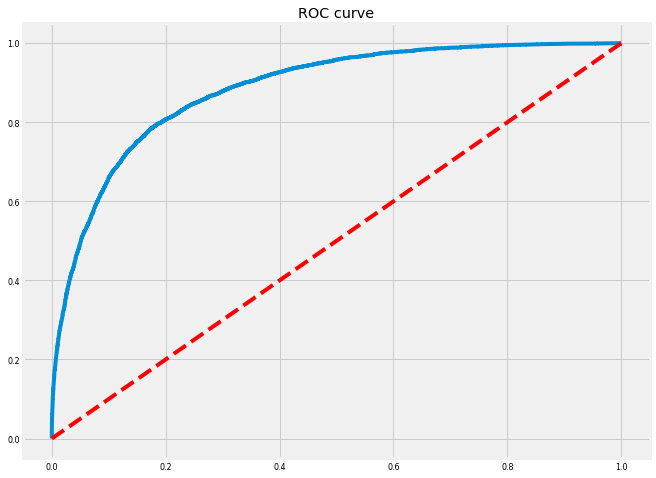

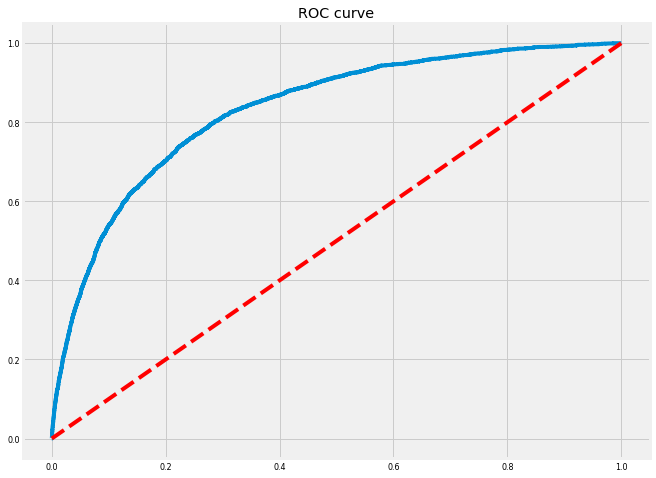

In [38]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_test, y_prob):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    print('auc is ',auc(fpr,tpr))
    plt.figure(figsize=(10,8))
    plt.title("ROC curve")
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.plot([0,1], [0,1],'r--')

y_train_hat=model.predict(X_train)
y_test_hat=model.predict(X_test)
y_train_prob=model.predict_proba(X_train)[:,1]
y_test_prob=model.predict_proba(X_test)[:,1]
plot_roc(y_train, y_train_prob)
plot_roc(y_test, y_test_prob)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, accuracy_score,confusion_matrix, roc_curve, auc,classification_report, recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


models={}
for i,model in enumerate([SVC(),LogisticRegression(),RandomForestClassifier()]):
    model.fit(X_train, y_train)
    y_train_hat=model.predict(X_train)  
    models[i]=model
    print('model',model)
    print('f1',f1_score(y_train,y_train_hat))
    print('-'*60)

In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score,confusion_matrix, roc_curve, auc,classification_report, recall_score
from sklearn.svm import SVC 


for model in models.values():
    # y_train_hat=model.predict(X_train) 
    print('model',model)
#     print('f1',f1_score( y_train_hat,y_train))
#     print('positive recall',precision_recall_fscore_support(y_train_hat,y_train)[1][1])
    print('-'*60)

In [ ]:
# y_train_hat=models[0].predict(X_train) 
# y_test_hat=models[0].predict(X_test)
# fpr, tpr, _ = roc_curve(y_test,y_test_hat)
# print(auc(fpr,tpr))

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
y_train_hat=models[0].predict(X_train) 
print('分类报告\n',classification_report(y_train, y_train_hat))
print('混淆矩阵\n',confusion_matrix(y_train, y_train_hat))

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
y_train_hat=models[1].predict(X_train) 
print('分类报告\n',classification_report(y_train, y_train_hat))
print('混淆矩阵\n',confusion_matrix(y_train, y_train_hat))

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
y_train_hat=models[2].predict(X_train) 
print('分类报告\n',classification_report(y_train, y_train_hat))
print('混淆矩阵\n',confusion_matrix(y_train, y_train_hat))

In [ ]:
def roc(y_test, y_predict):
    fpr, tpr, _ = roc_curve(y_test, y_predict)
#     print(auc(fpr,tpr))
    plt.figure(figsize=(10,8))
    plt.title("ROC curve(auc score=%.4f)"%auc(fpr,tpr))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.plot([0,1], [0,1],'r--')
    # plt.legend(loc="lower right")
roc(y_test, y_test_hat)

In [39]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_test, y_prob):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
#     print('auc is ',auc(fpr,tpr))
    plt.figure(figsize=(10,8))
    plt.title("ROC curve(auc score=%.4f)"%auc(fpr,tpr))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.plot([0,1], [0,1],'r--')

y_train_hat=models[2].predict(X_train)
# y_test_hat=model.predict(X_test)
y_train_prob=models[2].predict_proba(X_train)[:,1]
y_test_prob=models[2].predict_proba(X_test)[:,1]
roc(y_train_hat,y_train)
# plot_roc(y_train, y_train_prob)
plot_roc(y_test, y_test_prob)

NameError: name 'models' is not defined

In [ ]:
# y_train_hat=models[1].predict(X_train) 
# y_test_hat=models[1].predict(X_test)
# fpr, tpr, _ = roc_curve(y_test,y_test_hat)
# print(auc(fpr,tpr))

# from sklearn.metrics import classification_report,confusion_matrix
# print('分类报告\n',classification_report(y_test, y_test_hat))
# print('混淆矩阵\n',confusion_matrix(y_test, y_test_hat))


# print('分类报告\n',classification_report(y_train_hat, y_train))
# print('混淆矩阵\n',confusion_matrix(y_train, y_train_hat))

# roc(y_test, y_test_hat)
# roc(y_train, y_train_hat)

In [43]:
model_2=RandomForestClassifier()
model_2.fit(X_train, y_train)

y_train_hat=model_2.predict(X_train) 
y_test_hat=model_2.predict(X_test)


print('训练集上：')
print('分类报告\n',classification_report(y_train, y_train_hat))

print('\n测试集上：')

y_test_hat=model_2.predict(X_test)
print('分类报告\n',classification_report(y_test, y_test_hat))

训练集上：
分类报告
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     95309
          1       1.00      1.00      1.00     51042

avg / total       1.00      1.00      1.00    146351


测试集上：
分类报告
              precision    recall  f1-score   support

          0       0.94      0.98      0.96     40816
          1       0.34      0.15      0.21      2936

avg / total       0.90      0.92      0.91     43752



In [ ]:
from sklearn.metrics import roc_auc_score
y_test_prob=models[2].predict_proba(X_test)[:,1]
auc_score=roc_auc_score(y_test,y_test_prob)
print(auc_score)

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_test, y_predict):
    fpr, tpr, _ = roc_curve(y_test, y_predict)
    print('auc is ',auc(fpr,tpr))
    plt.figure(figsize=(10,8))
    plt.title("ROC curve")
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.plot([0,1], [0,1],'r--')

plot_roc(y_train, y_train_hat)
plot_roc(y_test, y_test_hat)

In [ ]:
# model_to_set = LinearSVC(penalty='l2',multi_class='ovr',random_state=0)
# parameters = {
#     "tol":np.arange(1e-8,1e-6,1e-7),
#     "max_iter":range(1000,10000,1000)
# }
# model_tunning=GridSearchCV(model_to_set,param_grid=parameters,scoring='f1',cv=5)
# model_tunning.fit(x_train, y_train)
# print(model_tunning.best_score_,model_tunning.best_params_)
# return model_tunning.best_params_

# 随机森林

In [ ]:
rf_model.best_params_

In [ ]:
best_est_rf = rf_model.best_estimator_
best_est_rf.fit(X_train, y_train)
y_pred_rf = best_est_rf.predict_proba(X_test)[:,1]

# 12.4验证

In [ ]:
plot_roc(y_test, y_pred_rf)

​ ROC的全称是“受试者工作特征”（Receiver Operating Characteristic）曲线，首先是由二战中的电子工程师和雷达工程师发明的，用来侦测战场上的敌军载具（飞机、船舰），也就是信号检测理论。之后很快就被引入了心理学来进行信号的知觉检测。此后被引入机器学习领域，用来评判分类、检测结果的好坏。因此，ROC曲线是非常重要和常见的统计分析方法。
ROC曲线的绘制步骤如下：

1.假设已经得出一系列样本被划分为正类的概率Score值，按照大小排序。
2.从高到低，依次将“Score”值作为阈值threshold，当测试样本属于正样本的概率大于或等于这个threshold时，我们认为它为正样本，否则为负样本。举例来说，对于某个样本，其“Score”值为0.6，那么“Score”值大于等于0.6的样本都被认为是正样本，而其他样本则都认为是负样本。
3.每次选取一个不同的threshold，得到一组FPR和TPR，以FPR值为横坐标和TPR值为纵坐标，即ROC曲线上的一点。
4.根据3中的每个坐标点，画图。

利用ROC曲线评价模型性能，通过计算AUC(Area Under Curve)可知。
​AUC表示ROC曲线下的面积，主要用于衡量模型的泛化性能，即分类效果的好坏。AUC是衡量二分类模型优劣的一种评价指标，表示正例排在负例前面的概率。一般在分类模型中，预测结果都是以概率的形式表现，如果要计算准确率，通常都会手动设置一个阈值来将对应的概率转化成类别，这个阈值也就很大程度上影响了模型准确率的计算。

之所以采用AUC来评价，主要还是考虑到ROC曲线本身并不能直观的说明一个分类器性能的好坏，而AUC值作为一个数量值，具有可比较性，可以进行定量的比较。

ROC越往左上突出，AUC越大，模型的性能越好。

可见随机森林比逻辑回归有更好的模型表现。不仅如此，随机森林还可以用于解释模型各特征的重要性程度，可以看出特征Combine Past Due是对模型影响最大的特征。




In [ ]:
def plot_feature_importances(model):
    plt.figure(figsize=(10,8))
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(models[2])

In [ ]:
# 可视化随机森林的特征重要性
model=models[2]
plt.figure(figsize=(10,8))
n_features = X_train.shape[1]
plt.barh(range(n_features), model.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")